In [155]:
! pip3 install -q transformers datasets

In [156]:
import logging

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [157]:
CATEGORIES = ["action", "adventure", "animation", "biography", "comedy", "crime", "documentary", "drama", "family",
              "fantasy", "film_noir", "history", "horror", "music", "musical", "mystery", "romance", "sci_fi",
              "short", "sport", "superhero", "thriller", "war", "western"]

In [158]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [159]:
from transformers import AutoFeatureExtractor, ResNetForImageClassification

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")
base_model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

In [140]:
import torch
import torchvision.transforms as transforms
import os
import pandas as pd
from skimage import io, color
from torch.utils.data import Dataset

class FilmFeatureExtractor(object):
    def __call__(self, image, targets):
        sample = feature_extractor(image, return_tensors='pt')
        sample["labels"] = targets
        
        return sample

class FilmDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(os.path.join(self.root_dir, csv_file))
        self.shape = self.annotations.shape
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index]['poster_path'])
        image = io.imread(img_path)
        if len(image.shape) < 3:
          image = color.gray2rgb(image)
        labels = torch.tensor(self.annotations.iloc[index][CATEGORIES], dtype=torch.float32)
        data = self.transform(image, labels)
        
        return data

df = FilmDataset(
    csv_file="data/preprocessed.csv",
    root_dir="drive/MyDrive",
    transform=FilmFeatureExtractor(),
)


In [160]:
df.__getitem__(0)

{'pixel_values': tensor([[[[-0.5253, -0.5767, -0.5938,  ...,  1.4954,  1.4954,  1.4612],
          [-0.5938, -0.6452, -0.6794,  ...,  1.5639,  1.5468,  1.5468],
          [-0.6452, -0.6965, -0.7479,  ...,  1.5468,  1.4783,  1.5468],
          ...,
          [-1.3987, -1.3644, -1.3815,  ..., -1.4500, -1.5357, -1.6042],
          [-1.4843, -1.4329, -1.4158,  ..., -1.5699, -1.5185, -1.5185],
          [-1.6384, -1.5870, -1.5528,  ..., -1.8097, -1.8610, -1.8439]],

         [[-0.3025, -0.3550, -0.3901,  ...,  1.4832,  1.4657,  1.4307],
          [-0.3901, -0.4601, -0.5126,  ...,  1.5532,  1.5007,  1.5182],
          [-0.4251, -0.4951, -0.5476,  ...,  1.5357,  1.4482,  1.5182],
          ...,
          [-1.1604, -1.1253, -1.1429,  ..., -0.9853, -1.0903, -1.1779],
          [-1.2829, -1.2479, -1.2129,  ..., -1.1078, -1.0903, -1.1253],
          [-1.4580, -1.4230, -1.3704,  ..., -1.3704, -1.4230, -1.4405]],

         [[ 0.5659,  0.5311,  0.5136,  ...,  0.7054,  0.7576,  0.7054],
          [ 0

In [161]:
id2label = {idx:label for idx, label in enumerate(CATEGORIES)}
label2id = {label:idx for idx, label in enumerate(CATEGORIES)}

# Model without fine tuning

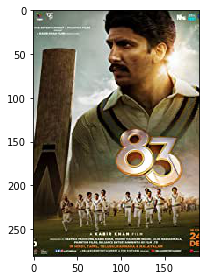

In [183]:
index = 1
poster = df.__getitem__(index)
io.imshow(io.imread(os.path.join(df.root_dir, df.annotations.iloc[index]['poster_path'])))

In [163]:
with torch.no_grad():
  logits = base_model(pixel_values = poster['pixel_values']).logits
predicted_label = logits.argmax(-1).item()
print(base_model.config.id2label[predicted_label])

assault rifle, assault gun


## Train test split

In [164]:
train_size = int(0.4 * df.shape[0])
eval_size = int(0.4 * df.shape[0])
test_size = df.shape[0] - train_size - eval_size

print(df.shape[0], train_size, eval_size, test_size)

4165 1666 1666 833


In [165]:
df_train, df_eval, df_test = torch.utils.data.random_split(df, [train_size, eval_size, test_size])

## Model

In [166]:
model = ResNetForImageClassification.from_pretrained(
    "microsoft/resnet-50",
    problem_type="multi_label_classification", 
    ignore_mismatched_sizes=True,
    num_labels=len(CATEGORIES),
    id2label=id2label,
    label2id=label2id,
    )

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([24, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([24]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [167]:
with torch.no_grad():
  logits = model(pixel_values = poster['pixel_values']).logits
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

documentary


In [168]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
import numpy as np
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    logging.warning(probs)

    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    logging.warning(y_pred)
    logging.warning(np.sum(np.where(probs >= threshold)))

    # finally, compute metrics
    y_true = labels
    logging.warning(y_true)

    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)

    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}

    return metrics

def compute_metrics(p: EvalPrediction):
    result = multi_label_metrics(predictions=p.predictions, labels=p.label_ids)

    return result

In [173]:
import torch

def collate_fn(batch):
  return {
      'pixel_values': torch.stack([x['pixel_values'][0] for x in batch]),
      'labels': torch.stack([x['labels'] for x in batch])
  }

In [174]:
from transformers import TrainingArguments
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="drive/MyDrive/data/img", 
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [175]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=df_train,
    eval_dataset=df_eval,
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)

In [176]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1666
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1045
  Number of trainable parameters = 23557208


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.560125,0.147737,0.537641,0.003001
2,No log,0.489806,0.172568,0.545070,0.004202
3,0.535000,0.444875,0.184198,0.548687,0.004202
4,0.535000,0.432534,0.180925,0.547703,0.004802
5,0.406300,0.416418,0.201428,0.554218,0.004802


***** Running Evaluation *****
  Num examples = 1666
  Batch size = 8
--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", lin

TrainOutput(global_step=1045, training_loss=0.4676443309875196, metrics={'train_runtime': 949.1631, 'train_samples_per_second': 8.776, 'train_steps_per_second': 1.101, 'total_flos': 1.7723004990308352e+17, 'train_loss': 0.4676443309875196, 'epoch': 5.0})

In [184]:
with torch.no_grad():
  logits = trainer.model(pixel_values = poster['pixel_values']).logits
predicted_label = logits.argmax(-1).item()
print(trainer.model.config.id2label[predicted_label])

RuntimeError: ignored

In [180]:
model = ResNetForImageClassification.from_pretrained(os.path.join(training_args.output_dir, 'checkpoint-1045'))

loading configuration file drive/MyDrive/data/img/checkpoint-1045/config.json
Model config ResNetConfig {
  "_name_or_path": "microsoft/resnet-50",
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    4,
    6,
    3
  ],
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,
    2048
  ],
  "id2label": {
    "0": "action",
    "1": "adventure",
    "2": "animation",
    "3": "biography",
    "4": "comedy",
    "5": "crime",
    "6": "documentary",
    "7": "drama",
    "8": "family",
    "9": "fantasy",
    "10": "film_noir",
    "11": "history",
    "12": "horror",
    "13": "music",
    "14": "musical",
    "15": "mystery",
    "16": "romance",
    "17": "sci_fi",
    "18": "short",
    "19": "sport",
    "20": "superhero",
    "21": "thriller",
    "22": "war",
    "23": "western"
  },
  "label2id": {
    "action": 0,
    "adventure": 1,
    "animation": 2,
    "biography

In [182]:
poster = df_test.__getitem__(0)
with torch.no_grad():
  logits = model(pixel_values = poster['pixel_values']).logits
print(poster['labels'])
print(logits)

tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])
tensor([[-1.0567, -1.0746, -1.4298, -1.6180, -0.7705, -1.1588, -1.5799,  0.0106,
         -1.3971, -1.4738, -1.5308, -1.4470, -1.6698, -1.2861, -1.6532, -1.4849,
         -1.3001, -1.5252, -1.7332, -1.4725, -1.6322, -1.4096, -1.6236, -1.7308]])
